In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import sys

from google.colab import drive
drive.mount("/content/drive", force_remount=True)
data_dir = ("/content/drive/MyDrive/image_stitching_project/")

MessageError: Error: credential propagation was unsuccessful

In [ ]:
f0 = data_dir + "train/arr_0.npy"
f1 = data_dir + "train/arr_1.npy"
f2 = data_dir + "train/arr_2.npy"
f3 = data_dir + "train/arr_3.npy"
f4 = data_dir + "train/arr_4.npy"
valid_data = np.load(data_dir + "valid/arr_0.npy")
print("valid_data.shape:", valid_data.shape)
train_data = np.concatenate((np.load(f0), np.load(f1), np.load(f2), np.load(f3), np.load(f4)), axis=0)
print("train_data.shape:", train_data.shape)

valid_data.shape: (1000, 315, 315, 3)
train_data.shape: (15000, 315, 315, 3)


In [ ]:
mask_denom = 5
assert (315 % mask_denom == 0)
slice_width = 315 // mask_denom
left_cutoff = slice_width * (mask_denom // 2)
right_cutoff = left_cutoff + slice_width
print("mask_denom:", mask_denom)
print("slice_width:", slice_width)
print("left_cutoff:", left_cutoff)
print("right_cutoff:", right_cutoff)

mask_denom: 5
slice_width: 63
left_cutoff: 126
right_cutoff: 189


In [ ]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.architecture = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 3, strides=3, padding="same"),
        tf.keras.layers.Conv2D(64, 3, strides=3, padding="same"),
        tf.keras.layers.Conv2D(128, 7, strides=mask_denom, padding="same"),
        tf.keras.layers.Conv2DTranspose(64, 7, strides=(mask_denom, 1), padding="same"),
        tf.keras.layers.Conv2DTranspose(32, 3, strides=3, padding="same"),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=3, padding="same", activation="sigmoid")
    ])
  def call(self, inputs):
    return self.architecture(inputs)

In [ ]:
model = Model()
model.build(input_shape=(1, 315, 315, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
model.summary()

NameError: name 'Model' is not defined

In [ ]:
masked_valid_data = np.copy(valid_data)
masked_valid_data[:, :, left_cutoff:right_cutoff, :] = 1.0
masked_train_data = np.copy(train_data)
masked_train_data[:, :, left_cutoff:right_cutoff, :] = 1.0

In [ ]:
history1 = model.fit(x=masked_train_data, y=train_data[:, :, left_cutoff:right_cutoff, :], batch_size=100, epochs=20, validation_data=(masked_valid_data, valid_data[:, :, left_cutoff:right_cutoff, :]), shuffle=True)

Epoch 1/20
150/150 [==============================] - 24s 148ms/step - loss: 0.0546 - val_loss: 0.0331
Epoch 2/20
150/150 [==============================] - 18s 123ms/step - loss: 0.0289 - val_loss: 0.0281
Epoch 3/20
150/150 [==============================] - 19s 124ms/step - loss: 0.0273 - val_loss: 0.0270
Epoch 4/20
150/150 [==============================] - 18s 121ms/step - loss: 0.0268 - val_loss: 0.0264
Epoch 5/20
150/150 [==============================] - 18s 121ms/step - loss: 0.0262 - val_loss: 0.0261
Epoch 6/20
150/150 [==============================] - 18s 123ms/step - loss: 0.0258 - val_loss: 0.0253
Epoch 7/20
150/150 [==============================] - 18s 122ms/step - loss: 0.0253 - val_loss: 0.0248
Epoch 8/20
150/150 [==============================] - 18s 121ms/step - loss: 0.0250 - val_loss: 0.0244
Epoch 9/20
150/150 [==============================] - 18s 122ms/step - loss: 0.0246 - val_loss: 0.0239
Epoch 10/20
150/150 [==============================] - 18s 123ms/step - l

In [ ]:
history2 = model.fit(x=masked_train_data, y=train_data[:, :, left_cutoff:right_cutoff, :], batch_size=100, epochs=30, validation_data=(masked_valid_data, valid_data[:, :, left_cutoff:right_cutoff, :]), shuffle=True)

Epoch 1/30
150/150 [==============================] - 21s 139ms/step - loss: 0.0208 - val_loss: 0.0204
Epoch 2/30
150/150 [==============================] - 18s 118ms/step - loss: 0.0206 - val_loss: 0.0203
Epoch 3/30
150/150 [==============================] - 18s 118ms/step - loss: 0.0205 - val_loss: 0.0200
Epoch 4/30
150/150 [==============================] - 18s 120ms/step - loss: 0.0203 - val_loss: 0.0198
Epoch 5/30
150/150 [==============================] - 18s 119ms/step - loss: 0.0201 - val_loss: 0.0197
Epoch 6/30
150/150 [==============================] - 18s 121ms/step - loss: 0.0201 - val_loss: 0.0200
Epoch 7/30
150/150 [==============================] - 18s 120ms/step - loss: 0.0199 - val_loss: 0.0196
Epoch 8/30
150/150 [==============================] - 18s 121ms/step - loss: 0.0197 - val_loss: 0.0193
Epoch 9/30
150/150 [==============================] - 18s 120ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 10/30
150/150 [==============================] - 18s 121ms/step - l

In [ ]:
model.save_weights(data_dir + "checkpoint_1")

In [ ]:
tot_lst = history1.history["val_loss"] + history2.history["val_loss"]
print(len(tot_lst))
tot_lst = np.array(tot_lst)
print(tot_lst.shape)
np.save(data_dir + "checkpoint_1_val_losses", tot_lst)

50
(50,)


In [ ]:
stitch_input = np.concatenate((masked_valid_data[:5, :, :right_cutoff, :], masked_valid_data[5:10, :, right_cutoff:, :]), axis=2)
print(stitch_input.shape)

(5, 315, 315, 3)


1/1 [==============================] - 0s 29ms/step


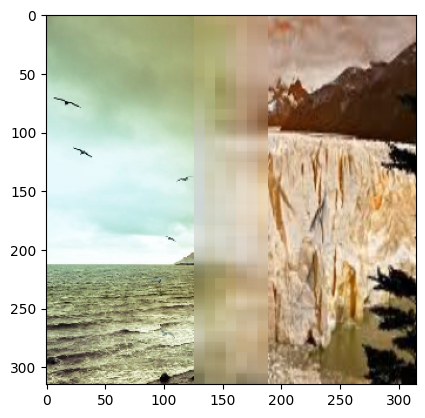

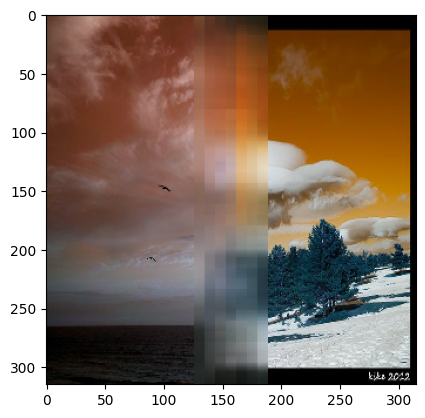

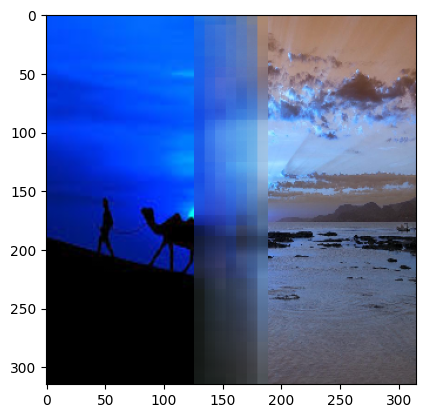

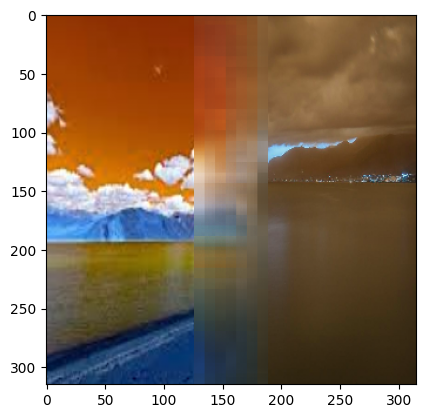

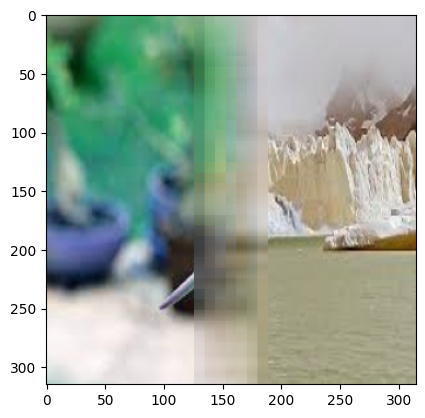

In [ ]:
stitch_pred = model.predict(stitch_input)
stitched_imgs = np.concatenate((valid_data[:5, :, :left_cutoff, :], stitch_pred, valid_data[5:10, :, right_cutoff:, :]), axis=2)
for i in range(5):
  plt.imshow(stitched_imgs[i, :, :, :])
  plt.show()